# HTS Figures

To recreate original MolPAL publication figures, go to the [section below](#recreating-figures-from-the-original-publication)

In [1]:
from pathlib import Path
import sys

from matplotlib import pyplot as plt, ticker
from matplotlib.axes import Axes
import numpy as np
import seaborn as sns

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment
from scripts.utils import build_true_dict, extract_smis

sns.set_theme("talk", "white")
sns.set_palette("dark")

HTS_DIR = Path.home() / "active-projects/molpal-pruning/runs/HTS/full/al/0.004"
HTS_SB_DIR = Path.home() / "active-projects/molpal-pruning/runs/HTS/full/sb"

SIZE = 2.1e6
k = 1000

d_smi_score = build_true_dict("../data/EnamineHTS_scores.csv")

smis = extract_smis("../libraries/EnamineHTS.csv")
y_true = np.array([d_smi_score.get(smi) for smi in smis], float)

hts_top_k = sorted(d_smi_score.items(), key=lambda kv: kv[1], reverse=True)[:k]

In [2]:
def plot_reward(ax, x, y, yerr, ls="-", alpha=1):
    ax.errorbar(
        x, y, yerr,
        fmt='o', ls=ls, color="darkgreen", mec="k", mew=2,
        capsize=5, capthick=2,
        alpha=alpha
    )

def annotate_ax(ax: Axes, x, y):
    ax.annotate(
        f"{y:0.3f}", xy=(x, y), xytext=(-60, -15),
        textcoords="offset points",
        fontsize=12, arrowprops=dict(arrowstyle="->")
    )


/home/degraff/molpal/notebooks/../scripts/experiment.py:28: UserWarning: Experiment has no checkpoints!
  warnings.warn("Experiment has no checkpoints!")


SB-0.004: 0.950


/home/degraff/molpal/notebooks/../scripts/experiment.py:28: UserWarning: Experiment has no checkpoints!
  warnings.warn("Experiment has no checkpoints!")


SB-0.020: 0.763
AL-0.004: 0.979


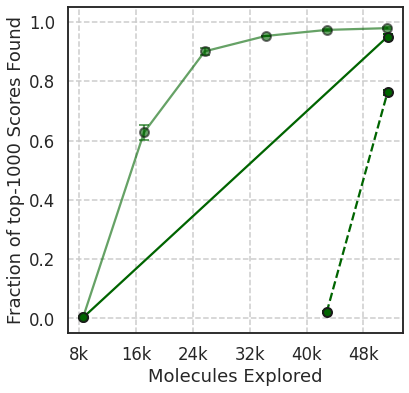

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

rs = []
for e in (HTS_SB_DIR / "0.004").iterdir():
    e = Experiment(e)
    r = [e.calculate_reward(i, hts_top_k, True)[2] for i in range(e.num_iters)]
    rs.append(r)
R = np.array(rs)

plot_reward(ax, e.num_acquired, R.mean(0), R.std(0))
print(f"SB-0.004: {R.mean(0)[-1]:0.3f}")

rs = []
for e in (HTS_SB_DIR / "0.020").iterdir():
    e = Experiment(e)
    r = [e.calculate_reward(i, hts_top_k, True)[2] for i in range(e.num_iters)]
    rs.append(r)
R = np.array(rs)

plot_reward(ax, e.num_acquired, R.mean(0), R.std(0), "--")
print(f"SB-0.020: {R.mean(0)[-1]:0.3f}")

rs = []
for e in HTS_DIR.iterdir():
    e = Experiment(e)
    r = [e.calculate_reward(i, hts_top_k, True)[2] for i in range(e.num_iters)]
    rs.append(r)
R = np.array(rs)

plot_reward(ax, e.num_acquired, R.mean(0), R.std(0), "-", 0.6)
print(f"AL-0.004: {R.mean(0)[-1]:0.3f}")

ax.grid(True, "major", "both", ls="--")

ax.set_ylabel(f"Fraction of top-{k} Scores Found")
ax.set_xlabel("Molecules Explored")

ax.set_ylim(-0.05, 1.05)
ax.xaxis.set_major_formatter(ticker.EngFormatter(sep=""))
ax.xaxis.set_major_locator(ticker.MultipleLocator(8000))

In [5]:
fig.savefig("../figures/hts/single-batch.pdf", dpi=400, bbox_inches="tight")

Text(0, 0.5, 'Error (kcal$\\cdot\\mathrm{mol}^{-1}$)')

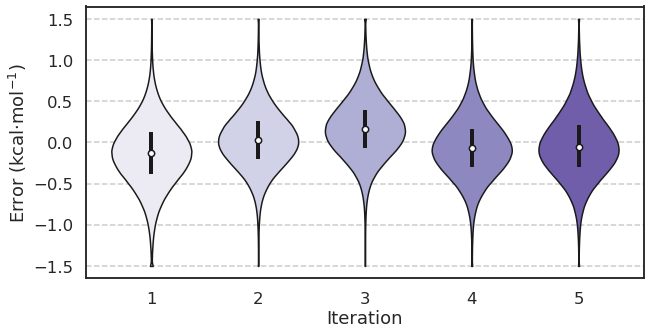

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

mask = ~np.isnan(y_true)

e = Experiment(next(HTS_DIR.iterdir()))

iters = list(range(1, e.num_iters))[::-1]

errors = []
for i in iters:
    y_pred, _ = e.predictions(i)
    errors.append((y_true - y_pred)[mask])
    
E = np.array(errors)

y1, y2 = np.percentile(E, [5, 95], axis=1, keepdims=True)
E_c = np.clip(E, -1.5, 1.5)

parts = ax.violinplot(E_c.T, widths=0.75, showextrema=False)
for pc, c in zip(parts['bodies'], sns.color_palette("Purples")):
    pc.set_facecolor(c)
    pc.set_edgecolor('k')
    pc.set_alpha(1)


x = np.arange(1, len(E)+1)
q1, m, q3 = np.percentile(E, [25, 50, 75], axis=1)

ax.scatter(x, m, marker='o', color="w", edgecolor="k", s=40, zorder=3)
ax.vlines(x, q1, q3, color="k", ls='-', lw=4)

ax.grid(True, "major", "y", ls="--")

ax.set_xlabel("Iteration")
ax.set_ylabel(r"Error (kcal$\cdot\mathrm{mol}^{-1}$)")

In [9]:
fig.savefig("../figures/hts/errors-violin_units.pdf", dpi=400, bbox_inches="tight")

## Recreating figures from the original publication

The figures in the original publication were generally multi-paneled with many traces, each corresponding to a different experimental setup. The below table summarizes these figures
| figure | panels | traces | k | metric |
| ------ | ------ | ------ | --- | --- |
| 10k | surrogate model | acquisition metric | 100 | scores |
| 50k | "..." | "..." | 500 | scores |
| HTS (2M) | batch size | surrogate model | 1000 | scores |
| AmpC (100M) | batch size | surrogate model | 50000 | scores |

The below cells will demonstrate how to create a single trace a single panel of one of these figures, but the general formula is as follows:

0. organize all of the runs of a given experimental setup (i.e., batch size, surrogate model, and acquisition metric) under some parent directory
1. extract the true top-$k$ molecules of the dataset for your desired figure
2. for each setup that you would like to plot, run the second cell with the appropriate value of `PARENT_DIR` and `ax` (if building a multi-panel figure). This step can get fairly tedious for a multi-panel figure with many traces, so it might be wise to leverage the organization of your directory structure and some nested `for`-loops to automate this
3. style the figure appropriately. Note that in the original publication we expressed performance as a _percentage_ of top-$k$. The current styling expresses performance as a _fraction_, but this is an easy change (c.f., line 10 in cell 2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

k = 1000

d_smi_score = build_true_dict("../data/EnamineHTS_scores.csv")
hts_top_k = sorted(d_smi_score.items(), key=lambda kv: kv[1], reverse=True)[:k]

In [ ]:
PARENT_DIR: Path

rs = []
for e in PARENT_DIR.iterdir():
    e = Experiment(e)
    r = [e.calculate_reward(i, hts_top_k, True)[2] for i in range(e.num_iters)]
    rs.append(r)
R = np.array(rs)

plot_reward(ax, e.num_acquired, R.mean(0), R.std(0), "-")

In [ ]:
ax.grid(True, "major", "both", ls="--")

ax.set_ylabel(f"Fraction of top-{k} Scores Found")
ax.set_xlabel("Molecules Explored")

ax.set_ylim(-0.05, 1.05)
ax.xaxis.set_major_formatter(ticker.EngFormatter(sep=""))
ax.xaxis.set_major_locator(ticker.MultipleLocator(8000))